## Problem 2c Error Analysis

I am going to use a TH1 of 0.002 and a TH2 of 0.001

In [46]:
import numpy as np
from tensorflow.keras.datasets import mnist,fashion_mnist
from skimage.util import view_as_windows
from pixelhop import Pixelhop
from skimage.measure import block_reduce
import xgboost as xgb
import warnings, gc
from sklearn.metrics import confusion_matrix, accuracy_score
# suppress warnings
warnings.filterwarnings("ignore")
import time

In [47]:
np.random.seed(1)

# Preprocess
N_Train_Reduced = 10000    # 10000
N_Train_Full = 60000       # 50000
N_Test = 10000             # 10000

BS = 2000 # batch size

def shuffle_data(X, y):
    shuffle_idx = np.random.permutation(y.size)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y

def select_balanced_subset(images, labels, use_num_images):
    '''
    select equal number of images from each classes
    '''
    num_total, H, W, C = images.shape
    num_class = np.unique(labels).size
    num_per_class = int(use_num_images / num_class)

    # Shuffle
    images, labels = shuffle_data(images, labels)

    selected_images = np.zeros((use_num_images, H, W, C))
    selected_labels = np.zeros(use_num_images)

    for i in range(num_class):
        selected_images[i * num_per_class:(i + 1) * num_per_class] = images[labels == i][:num_per_class]
        selected_labels[i * num_per_class:(i + 1) * num_per_class] = np.ones((num_per_class)) * i

    # Shuffle again
    selected_images, selected_labels = shuffle_data(selected_images, selected_labels)

    return selected_images, selected_labels

def Shrink(X, shrinkArg):
    #---- max pooling----
    pool = shrinkArg['pool']
    # Make two different things (if pool is True or if pool is False)
    # if False do nothing, if True, do 2x2 max-pooling
    out = X
    if pool is False:
        pass
    elif pool is True:
        N, H, W, C = X.shape
        pool_height, pool_width = 2, 2
        stride = 2
        x_reshaped = X.reshape(N, H // pool_height, pool_height,
                            W // pool_width, pool_width, C)
        out = x_reshaped.max(axis=2).max(axis=3)

    #---- neighborhood construction
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    pad = shrinkArg['pad']
    ch = X.shape[-1]

    # code from discussion
    # pad
    if pad > 0:
        out = np.pad(out,((0,0), (pad,pad), (pad,pad), (0,0)), 'reflect')

    # neighborhood construction
    out = view_as_windows(out, (1,win,win,ch), (1,stride,stride,ch))

    # return array
    #print((out.reshape(out.shape[0], out.shape[1], out.shape[2], -1)).shape)
    return out.reshape(out.shape[0], out.shape[1], out.shape[2], -1)

# example callback function for how to concate features from different hops
def Concat(X, concatArg):
    return X

# I changed this to take p2 as an argument so I can use different model names
def get_feat(X, p2, num_layers=3):
    output = p2.transform_singleHop(X,layer=0)
    if num_layers>1:
        for i in range(num_layers-1):
            output = p2.transform_singleHop(output, layer=i+1)
    return output

def reshape_feats(train_feats, test_feats):
    N_train, _, _, X_train = train_feats.shape
    N_test, _, _, X_test = test_feats.shape
    train = np.reshape(train_feats, (N_train, X_train))
    test = np.reshape(test_feats, (N_test, X_test))
    
    return train, test

In [48]:
# Which dataset to use
dataset = 'fashion-mnist'

In [49]:
# ---------- Load MNIST data and split ----------
if dataset == 'fashion-mnist':
    print('Loading FashionMNSIT')
    (x_train, y_train), (x_test,y_test) = fashion_mnist.load_data()
elif dataset == 'mnist':
    print('Loading MNIST')
    (x_train, y_train), (x_test,y_test) = mnist.load_data()


# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')[:,:,:,np.newaxis]
x_test = np.asarray(x_test,dtype='float32')[:,:,:,np.newaxis]
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')

# if use only 10000 images train pixelhop
x_train_reduced, y_train_reduced = select_balanced_subset(x_train, y_train, use_num_images=N_Train_Reduced)

x_train /= 255.0
x_test /= 255.0

Loading FashionMNSIT


In [50]:
# Setup the Shrink Arguments
shrinkArgs = [{'func':Shrink, 'win':5, 'stride':1, 'pad':2, 'pool':False},
               {'func':Shrink, 'win':5, 'stride':1, 'pad':0, 'pool':True},
               {'func':Shrink, 'win':5, 'stride':1, 'pad':0, 'pool':True}]
# Setup the Saab Arguments for both PixelHop++ and PixelHop
SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'cw':False},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True}]
# Setup Concat Arguments
concatArg = {'func':Concat}

In [51]:
# Construct PixelHop++ model
p2 = Pixelhop(depth=3, TH1=0.002, TH2=0.001, 
              SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)


In [52]:
# Fit the PixelHop++ Model
print('Fitting the PixelHop++ model...')
p2.fit(x_train_reduced)
print('Done.')

Fitting the PixelHop++ model...
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
Done.


In [53]:
print('Getting the hop3 training features for PixelHop++')
train_hop3_feats = get_feat(x_train, p2)
print('Done, getting the hop3 testing features for PixelHop++')
test_hop3_feats = get_feat(x_test, p2)
print('Done.')

print('Standardizing features...')
STD = np.std(train_hop3_feats, axis=0, keepdims=1)
train_hop3_feats = train_hop3_feats/STD
test_hop3_feats = test_hop3_feats/STD
print('Done.')

print('Reshaping the features...')
train_reshaped, test_reshaped = reshape_feats(train_hop3_feats, test_hop3_feats)
print('Done.')

Getting the hop3 training features for PixelHop++
Done, getting the hop3 testing features for PixelHop++
Done.
Standardizing features...
Done.
Reshaping the features...
Done.


In [54]:
clf = xgb.XGBClassifier(n_jobs=-1,
                    objective='multi:softprob',
                    # tree_method='gpu_hist', gpu_id=None,
                    max_depth=6,n_estimators=100,
                    min_child_weight=5,gamma=5,
                    subsample=0.8,learning_rate=0.1,
                    nthread=8,colsample_bytree=1.0)

print('Fitting xgboost on PixelHop++...')
clf.fit(train_reshaped, y_train)
print('Done.')

Fitting xgboost on PixelHop++...
[10:24:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done.


In [55]:
# get accuracy on test dataset
print('getting test accuracy of xgboost on PixelHop++...')
pred_test = clf.predict(test_reshaped)
pred_train = clf.predict(train_reshaped)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print(f'The testing accuracy of using PixelHop++ on a reduced training set with the xgboost classifier is : {acc_test*100}')
print(f'The training accuracy is : {acc_train*100}')

getting test accuracy of xgboost on PixelHop++...
The testing accuracy of using PixelHop++ on a reduced training set with the xgboost classifier is : 86.0
The training accuracy is : 91.21000000000001


### Confusion Matrix

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)

# labels for fashion-mnist
fashion_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [73]:
confusion_matrix(y_test, pred_test)

array([[846,   1,  16,  34,   4,   1,  87,   0,  11,   0],
       [  3, 961,   2,  25,   4,   0,   3,   0,   2,   0],
       [ 13,   1, 758,  12, 109,   0, 100,   0,   7,   0],
       [ 33,   6,  12, 872,  27,   2,  44,   0,   4,   0],
       [  0,   0,  89,  35, 802,   0,  67,   0,   7,   0],
       [  1,   0,   0,   1,   0, 945,   0,  38,   0,  15],
       [152,   0, 125,  34, 100,   0, 573,   0,  16,   0],
       [  0,   0,   0,   0,   0,  29,   0, 930,   0,  41],
       [  3,   0,   6,   6,   1,   6,  10,   3, 964,   1],
       [  0,   0,   0,   0,   0,  10,   0,  40,   1, 949]])

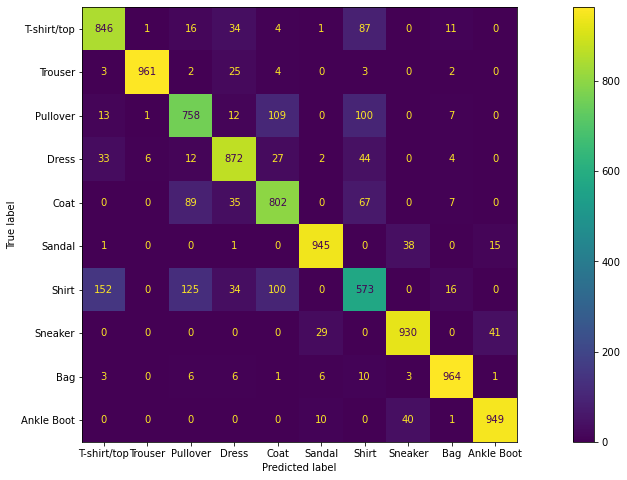

In [74]:
plot_confusion_matrix(clf, test_reshaped, y_test, display_labels=fashion_labels)
plt.show() 